# Pittsburgh Crash Categorical Data Clustering Using K-Modes
### Import Libraries, Load Data, and Filter Dataset

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 100)

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.ticker import FixedFormatter
import seaborn as sns

colors = ['#161415', '#03658C', '#D9A404', '#F2CAA7', '#D94032', '#AAA726']
# colors = ['#2F4073', '#048C7F', '#F2AC29', '#BF4141', '#F77979', '#F2CAA7']
sns.set_palette(sns.color_palette(colors))

import geopandas as gpd
from shapely.geometry import Point, Polygon

from kmodes.kmodes import KModes
from tqdm import tqdm

from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder

In [2]:
crash_df = pd.read_csv('data/crash-data.csv', low_memory=False)

# remove outlier points
crash_df = crash_df.loc[(crash_df['DEC_LONG'] < -79.7) & (crash_df['DEC_LONG'] > -80.4)].reset_index(drop=True)
crash_df = crash_df.loc[(crash_df['DEC_LAT'] < 40.7) & (crash_df['DEC_LAT'] > 40.2)].reset_index(drop=True)

# filter for City of Pittsburgh
crash_df = crash_df.loc[crash_df['MUNICIPALITY'] == 2301].reset_index(drop=True)

county = gpd.read_file('data/Allegheny_County_Boundary.geojson')
munis = gpd.read_file('data/Allegheny_County_Municipal_Boundaries.geojson')

In [3]:
munis_pittsburgh = munis[127:128] # select pittsburgh border to highlight

### Plot All Crashes in Filtered Dataset

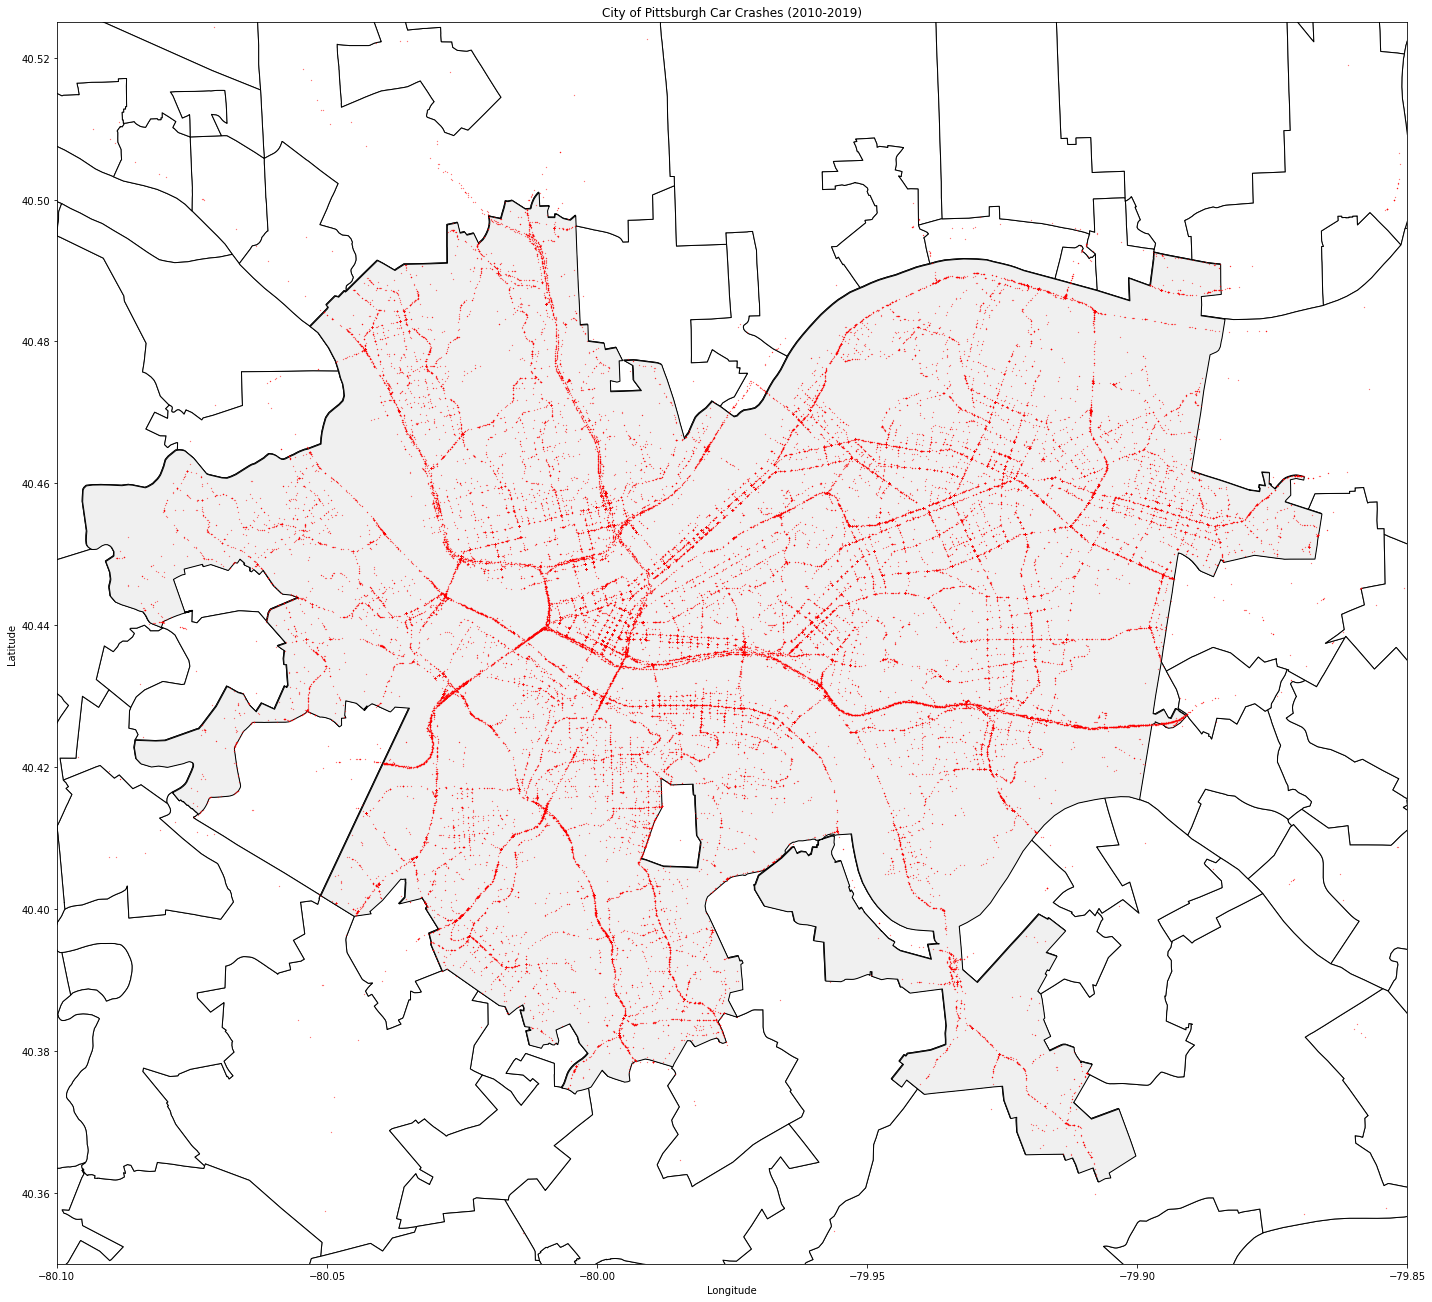

In [4]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=crash_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=crash_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='red', 
            marker='.',
            s=0.2)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.title('City of Pittsburgh Car Crashes (2010-2019)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('images/pitt_all_crashes.png')
plt.show()

# Part 1:  Categorical Clustering
### Drop Extraneous Columns

In [5]:
drop_cols = []

# remove columns with only one unique value
for col in crash_df.columns:
    if len(crash_df[col].unique()) == 1:
        drop_cols.append(col)

In [6]:
additional_drop_cols = [
    'CRASH_YEAR', 'MUNICIPALITY', 'POLICE_AGCY', 'LATITUDE', 'LONGITUDE', 'ACCESS_CTRL', 'STREET_NAME',
    'DEC_LAT', 'DEC_LONG', 'FLAG_CRN', 'ROADWAY_CRN', 'RDWY_SEQ_NUM', 'ADJ_RDWY_SEQ', 'ROADWAY_COUNTY',
    'ROAD_OWNER', 'ROUTE', 'SEGMENT', 'OFFSET', 'LN_CLOSE_DIR', 'SCHOOL_BUS_UNIT',
    'RDWY_SURF_TYPE_CD', 'SPEC_JURIS_CD', 'WORK_ZONE_TYPE', 'WORK_ZONE_LOC', 'CONS_ZONE_SPD_LIM', 
    'WORKERS_PRES', 'WZ_CLOSE_DETOUR', 'WZ_FLAGGER', 'WZ_LAW_OFFCR_IND', 'WZ_LN_CLOSURE', 'WZ_MOVING',
    'WZ_OTHER', 'WZ_SHLDER_MDN'
]

numeric_drop_cols = [
    'TIME_OF_DAY', 'TOTAL_UNITS', 'PERSON_COUNT', 'VEHICLE_COUNT', 'AUTOMOBILE_COUNT', 'MOTORCYCLE_COUNT',
    'BUS_COUNT', 'SMALL_TRUCK_COUNT', 'HEAVY_TRUCK_COUNT', 'SUV_COUNT', 'VAN_COUNT', 'BICYCLE_COUNT',
    'FATAL_COUNT', 'INJURY_COUNT', 'MAJ_INJ_COUNT', 'MOD_INJ_COUNT', 'MIN_INJ_COUNT', 'UNK_INJ_DEG_COUNT',
    'UNK_INJ_PER_COUNT', 'UNB_MAJ_INJ_COUNT', 'UNBELTED_OCC_COUNT', 'BELTED_MAJ_INJ_COUNT', 'BICYCLE_DEATH_COUNT',
    'BICYCLE_MAJ_INJ_COUNT', 'COMM_VEH_COUNT', 'DRIVER_COUNT_16YR', 'DRIVER_COUNT_17YR', 'DRIVER_COUNT_18YR',
    'DRIVER_COUNT_19YR', 'DRIVER_COUNT_20YR', 'DRIVER_COUNT_50_64YR', 'DRIVER_COUNT_65_74YR', 'DRIVER_COUNT_75PLUS',
    'LANE_CLOSED', 'LANE_COUNT', 'SPEED_LIMIT', 'UNB_DEATH_COUNT', 'BELTED_DEATH_COUNT', 'MCYCLE_DEATH_COUNT',
    'MCYCLE_MAJ_INJ_COUNT', 'PED_COUNT', 'PED_DEATH_COUNT', 'PED_MAJ_INJ_COUNT', 'MAX_SEVERITY_LEVEL',
    'EST_HRS_CLOSED', 'TOT_INJ_COUNT'
]

In [7]:
drop_cols += additional_drop_cols 
drop_cols += numeric_drop_cols

cat_crash_df = crash_df[crash_df['CRASH_YEAR'] > 2009].drop(drop_cols, axis=1).reset_index(drop=True)

final_drop_cols = []

for col in cat_crash_df.columns:
    if len(cat_crash_df[col].unique()) == 1:
        final_drop_cols.append(col)

cat_crash_df = cat_crash_df.drop(final_drop_cols, axis=1).reset_index(drop=True)

### Impute Missing Values

Imputation Values:
* HOUR_OF_DAY - 99 (unknown)
* WEATHER - 1 (most common)
* ROAD_CONDITION - 1 (most common)
* SCH_BUS_IND - 'N'
* SCH_ZONE_IND - 'N'
* NTFY_HIWY_MAINT - 'N'
* TFC_DETOUR_IND - 'N'
* LOCAL_ROAD - same value as LOCAL_ROAD_ONLY
* MODERATE_INJURY - 0
* RDWY_ORIENT - U (combine B and U)

In [8]:
cat_crash_df['HOUR_OF_DAY'] = cat_crash_df['HOUR_OF_DAY'].fillna(99)
cat_crash_df['WEATHER'] = cat_crash_df['WEATHER'].fillna(1)
cat_crash_df['ROAD_CONDITION'] = cat_crash_df['ROAD_CONDITION'].fillna(1)
cat_crash_df['SCH_BUS_IND'] = cat_crash_df['SCH_BUS_IND'].fillna('N')
cat_crash_df['SCH_ZONE_IND'] = cat_crash_df['SCH_ZONE_IND'].fillna('N')
cat_crash_df['NTFY_HIWY_MAINT'] = cat_crash_df['NTFY_HIWY_MAINT'].fillna('N')
cat_crash_df['TFC_DETOUR_IND'] = cat_crash_df['TFC_DETOUR_IND'].fillna('N')
cat_crash_df['MODERATE_INJURY'] = cat_crash_df['MODERATE_INJURY'].fillna(0)
cat_crash_df['RDWY_ORIENT'] = cat_crash_df['RDWY_ORIENT'].fillna('U')
cat_crash_df['LOCAL_ROAD'] = cat_crash_df['LOCAL_ROAD'].fillna(cat_crash_df['LOCAL_ROAD_ONLY'])
cat_crash_df.loc[cat_crash_df['RDWY_ORIENT'] == 'B', 'RDWY_ORIENT'] = 'U'

cat_crash_df = cat_crash_df.dropna()

### Label Encode Non-Numeric Features

In [9]:
encode_columns = ['SCH_BUS_IND', 'SCH_ZONE_IND', 'NTFY_HIWY_MAINT', 'RDWY_ORIENT', 'WORK_ZONE_IND', 'TFC_DETOUR_IND']

for col in encode_columns:
    le = LabelEncoder()
    cat_crash_df[col] = le.fit_transform(cat_crash_df[col])

## K-Modes Clustering

### Compare Initialization Methods

#### Huang Initialization

In [10]:
costs = []

for i in tqdm(range(2, 15)):
    kmode = KModes(
        n_clusters=i, 
        init='Huang',
        random_state=73,
        n_jobs=-1
    )

    y_kmode = kmode.fit_predict(cat_crash_df.drop(['CRASH_CRN'], axis=1))
    costs.append(kmode.cost_)


100%|██████████| 13/13 [27:14<00:00, 125.73s/it]


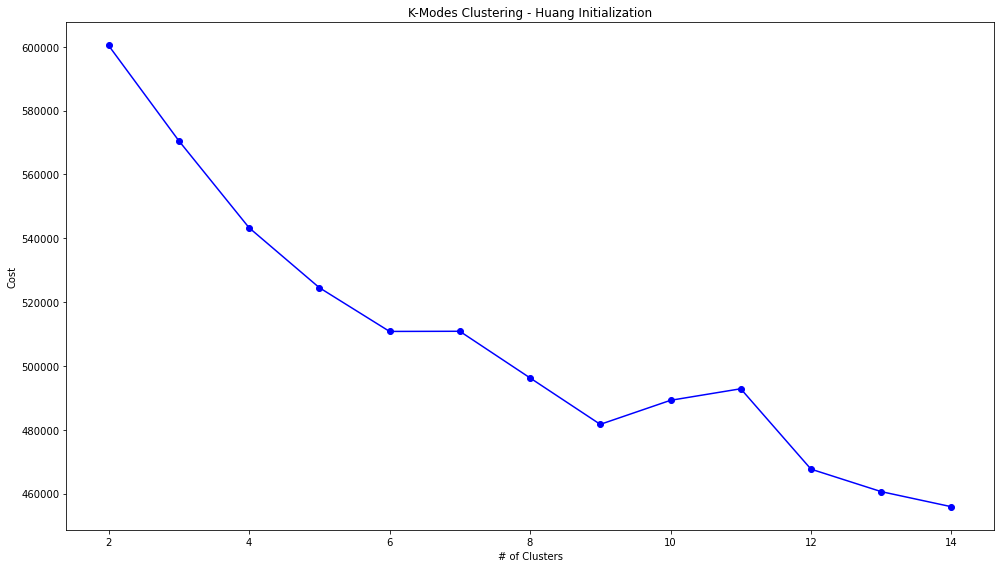

In [11]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(range(2, 15), costs, marker='o', color='blue')
plt.title('K-Modes Clustering - Huang Initialization')
plt.xlabel('# of Clusters')
plt.ylabel('Cost')
plt.tight_layout()
plt.savefig('images/huang_elbow.png')
plt.show()

#### Random Initialization

In [12]:
random_costs = []

for i in tqdm(range(2, 15)):
    kmode = KModes(
        n_clusters=i, 
        init='random',
        random_state=73,
        n_jobs=-1
    )

    y_kmode = kmode.fit_predict(cat_crash_df.drop(['CRASH_CRN'], axis=1))
    random_costs.append(kmode.cost_)

100%|██████████| 13/13 [13:01<00:00, 60.12s/it]


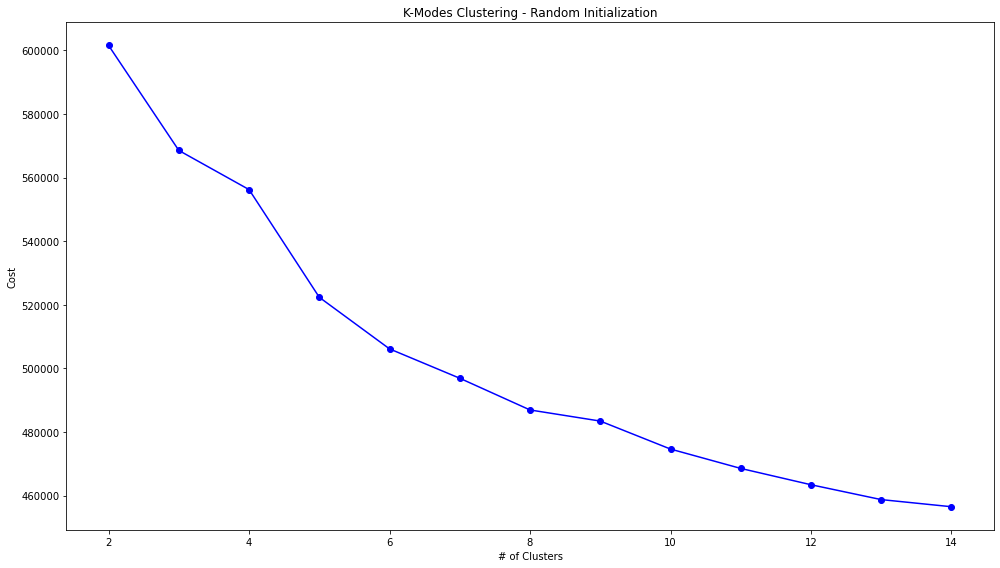

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))
plt.plot(range(2, 15), random_costs, marker='o', color='blue')
plt.title('K-Modes Clustering - Random Initialization')
plt.xlabel('# of Clusters')
plt.ylabel('Cost')
plt.tight_layout()
plt.savefig('images/random_elbow.png')
plt.show()

In [14]:
# elbow is at n_clusters=6 for both initializations but has a lower cost for random initialization 
# based on the this comparison select random initialization, n_clusters = 6

kmode = KModes(
        n_clusters=6, 
        init='random',
        n_jobs=-1,
        random_state=73
    )

cat_crash_df['KMODE_CLUSTER'] = kmode.fit_predict(cat_crash_df.drop(['CRASH_CRN'], axis=1))

# Part 2: Cluster Analysis

In [15]:
# number of observations in each cluster
cat_crash_df.groupby(['KMODE_CLUSTER']).agg('count')['CRASH_CRN']

KMODE_CLUSTER
0    9814
1    5329
2    6700
3    6795
4    6145
5    7899
Name: CRASH_CRN, dtype: int64

In [16]:
# proportion of observations in each cluster
cat_crash_df.groupby(['KMODE_CLUSTER']).agg('count')['CRASH_CRN'] / len(cat_crash_df)

KMODE_CLUSTER
0    0.229933
1    0.124854
2    0.156975
3    0.159201
4    0.143972
5    0.185066
Name: CRASH_CRN, dtype: float64

### Chi-square Test

In [17]:
# Example contingency table
pd.crosstab(cat_crash_df['KMODE_CLUSTER'], cat_crash_df['CRASH_MONTH'])

CRASH_MONTH     1    2    3    4    5    6    7    8    9    10   11   12
KMODE_CLUSTER                                                            
0              848  808  795  757  992  816  833  777  787  741  791  869
1              444  427  423  393  420  412  444  452  379  480  594  461
2              982  683  545  418  416  402  442  380  487  538  639  768
3              447  504  521  517  510  559  588  585  584  839  605  536
4              585  448  503  481  535  518  523  564  555  489  486  458
5              705  573  602  624  625  640  700  636  624  710  581  879

In [18]:
test_stats = []
p_vals = []
dof_vals = []

for col in cat_crash_df.columns[1:]:
    chi2_results = chi2_contingency(observed=pd.crosstab(cat_crash_df['KMODE_CLUSTER'], 
                                                         cat_crash_df[col]))
    test_stats.append(chi2_results[0])
    p_vals.append(chi2_results[1])
    dof_vals.append(chi2_results[2])
    

In [19]:
chi_test_df = pd.DataFrame(list(zip(cat_crash_df.columns[1:], 
                                    test_stats,
                                    p_vals,
                                    dof_vals)), columns=['variable', 'chi2_test_stat', 'p_value', 'dof'])

In [20]:
# variables for which we can reject the null hypothesis 
# we have selected a conservative p value of 0.01

chi_test_df [chi_test_df['p_value'] > 0.01]

variable  chi2_test_stat   p_value  dof
12      SCH_ZONE_IND        8.749910  0.119465    5
25     SHLDR_RELATED       12.087551  0.033608    5
41       SCHOOL_ZONE        8.749910  0.119465    5
55     TRAIN_TROLLEY        8.511229  0.130221    5
60        UNLICENSED       14.583377  0.012299    5
93   HAZARDOUS_TRUCK        7.879095  0.163026    5
102            TRAIN        4.088274  0.536778    5
103          TROLLEY        5.468969  0.361360    5

### Binary Variable Comparison

In [21]:
cat_number_df = pd.DataFrame(list(zip(cat_crash_df.columns[1:], 
                                      [len(cat_crash_df[x].value_counts()) for x in cat_crash_df.columns[1:]])), 
                             columns=['variable', 'number_of_cats'])

In [22]:
def convert_binary(x):
    if int(x.value_counts().index[0]) == 0 or len(x.value_counts()) < 2:
        return round((x.value_counts()/len(x)).values[0], 3)
    else:
        return round((x.value_counts()/len(x)).values[1], 3)

In [23]:
# generate table containing proportions of positive class (class=1) for all binary variables 
# add highlighting to max and min values of each row

binary_cats = cat_number_df.loc[cat_number_df['number_of_cats'] == 2]['variable'].values
binary_proportion_df = cat_crash_df.groupby(['KMODE_CLUSTER']).agg(lambda x: convert_binary(x)).transpose()
display_df = binary_proportion_df.loc[binary_proportion_df.index.isin(binary_cats)]
reverse_display_df = 1 - display_df
# reverse_display_df.style.highlight_max(color='lightgreen', axis=1).highlight_min(color='pink', axis=1)

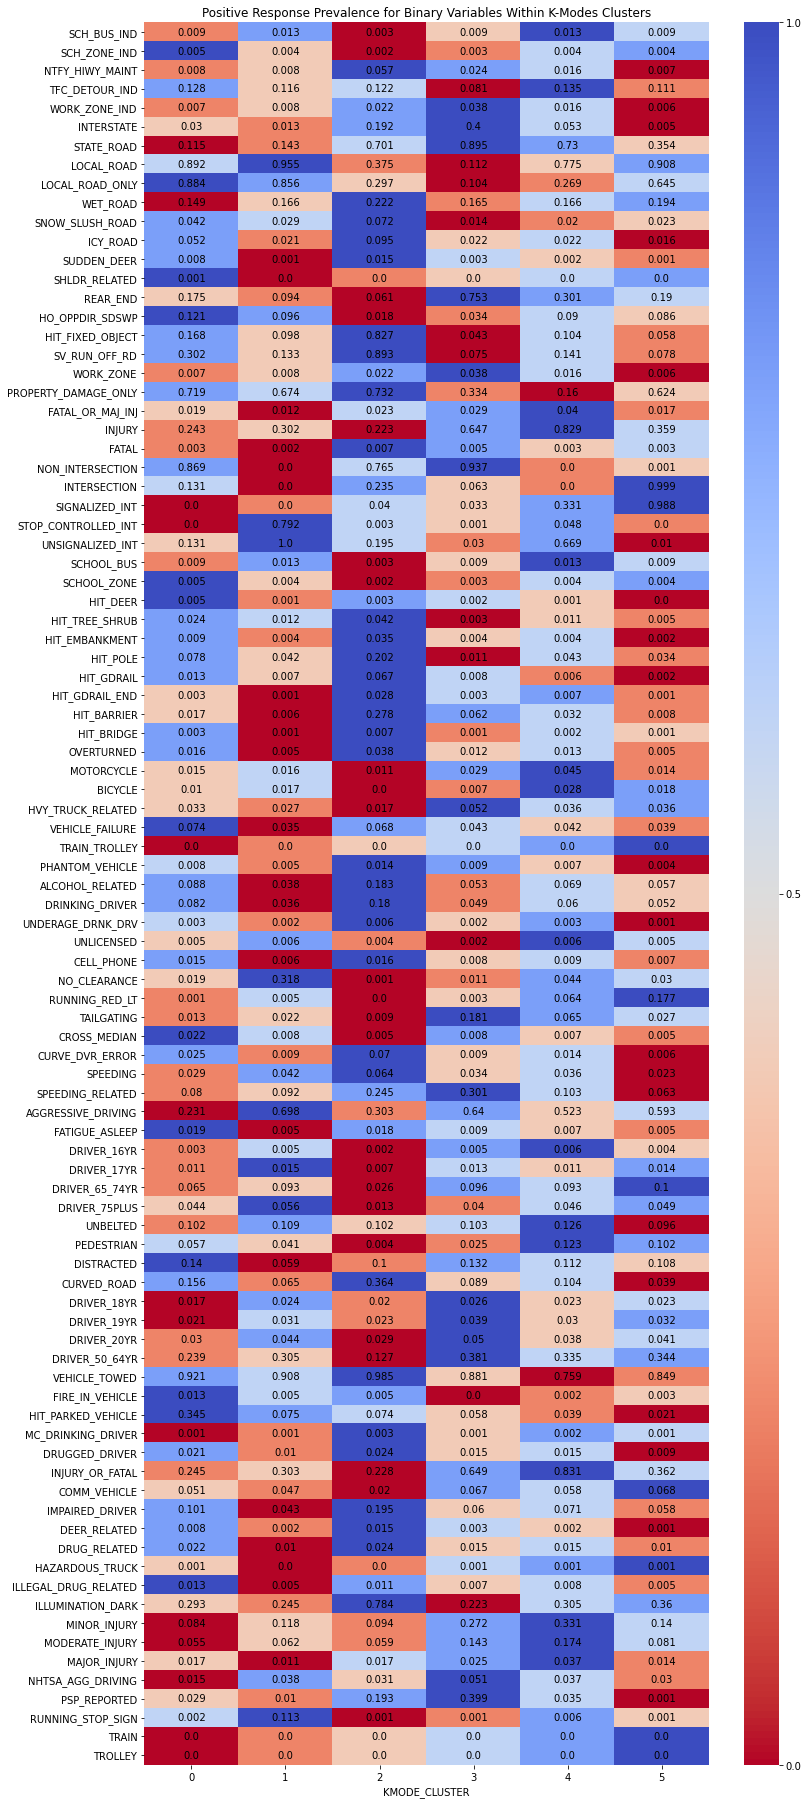

In [24]:
fig, ax = plt.subplots(figsize=(12,25))

b = np.argsort(np.argsort(reverse_display_df, axis=1), axis=1)

sns.heatmap(b, cmap='coolwarm_r', cbar_kws={'aspect': 50})
# im = plt.imshow(b, aspect="auto", cmap="coolwarm")
# plt.colorbar(im, ticks=np.array([0.0, 0.5, 1.0]), 
#              format=FixedFormatter(["low", "middle", "high"]))

for i in range(reverse_display_df.shape[0]):
    for j in range(reverse_display_df.shape[1]):
        plt.text(j+0.5,i+0.5,round(reverse_display_df[j][i], 3), ha="center", va="center")

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 2.5, 5.0])
cbar.set_ticklabels(['0.0', '0.5', '1.0'])
plt.tight_layout()
plt.title('Positive Response Prevalence for Binary Variables Within K-Modes Clusters')
plt.savefig('images/binary_comparison.png')

### Out-of-Cluster Proportions

In [25]:
# calculate out-of-cluster proportions for each cluster 

for i in range(6):
    print('Out-of-Cluter Proportions (Cluster', i, 'Excluded)')
    full_proportion_df = pd.DataFrame(cat_crash_df[cat_crash_df['KMODE_CLUSTER'] != i].agg(lambda x: convert_binary(x)).transpose(), columns=['proportion'])
    full_display_df = full_proportion_df.loc[full_proportion_df.index.isin(binary_cats)]
    reverse_full_display_df = 1 - full_display_df
    print(reverse_full_display_df.sort_index())
    print('\n')

Out-of-Cluter Proportions (Cluster 0 Excluded)
                      proportion
AGGRESSIVE_DRIVING         0.548
ALCOHOL_RELATED            0.081
BICYCLE                    0.014
CELL_PHONE                 0.009
COMM_VEHICLE               0.053
CROSS_MEDIAN               0.007
CURVED_ROAD                0.132
CURVE_DVR_ERROR            0.022
DEER_RELATED               0.004
DISTRACTED                 0.104
DRINKING_DRIVER            0.076
DRIVER_16YR                0.004
DRIVER_17YR                0.012
DRIVER_18YR                0.023
DRIVER_19YR                0.031
DRIVER_20YR                0.041
DRIVER_50_64YR             0.299
DRIVER_65_74YR             0.081
DRIVER_75PLUS              0.040
DRUGGED_DRIVER             0.015
DRUG_RELATED               0.015
FATAL                      0.004
FATAL_OR_MAJ_INJ           0.024
FATIGUE_ASLEEP             0.009
FIRE_IN_VEHICLE            0.003
HAZARDOUS_TRUCK            0.001
HIT_BARRIER                0.078
HIT_BRIDGE                 0.

                      proportion
AGGRESSIVE_DRIVING         0.443
ALCOHOL_RELATED            0.088
BICYCLE                    0.014
CELL_PHONE                 0.011
COMM_VEHICLE               0.050
CROSS_MEDIAN               0.011
CURVED_ROAD                0.146
CURVE_DVR_ERROR            0.025
DEER_RELATED               0.006
DISTRACTED                 0.109
DRINKING_DRIVER            0.083
DRIVER_16YR                0.004
DRIVER_17YR                0.012
DRIVER_18YR                0.021
DRIVER_19YR                0.027
DRIVER_20YR                0.036
DRIVER_50_64YR             0.267
DRIVER_65_74YR             0.074
DRIVER_75PLUS              0.041
DRUGGED_DRIVER             0.016
DRUG_RELATED               0.017
FATAL                      0.004
FATAL_OR_MAJ_INJ           0.022
FATIGUE_ASLEEP             0.012
FIRE_IN_VEHICLE            0.006
HAZARDOUS_TRUCK            0.001
HIT_BARRIER                0.065
HIT_BRIDGE                 0.003
HIT_DEER                   0.002
HIT_EMBANK

### Non-Binary Variable Comparison

In [26]:
non_binary_cats = cat_number_df.loc[cat_number_df['number_of_cats'] != 2]['variable'].values

def comparison_count(df, comparison_feature, column_list):
    for col in column_list:
        fig, ax = plt.subplots(figsize=(16,8))
        sns.countplot(x=col, hue=comparison_feature, data=df)
        plt.show()

In [27]:
# comparison_count(cat_crash_df, 'KMODE_CLUSTER', non_binary_cats)

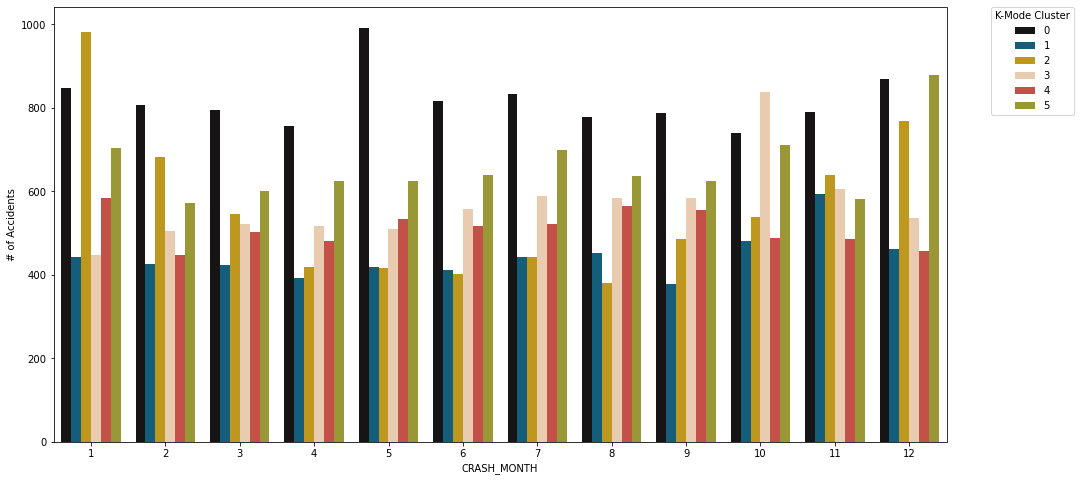

In [28]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x='CRASH_MONTH', hue='KMODE_CLUSTER', data=cat_crash_df)
# plt.ylim(0, 1200)
plt.legend(title='K-Mode Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.ylabel('# of Accidents')
plt.savefig('images/month_clusters.png')
plt.show()

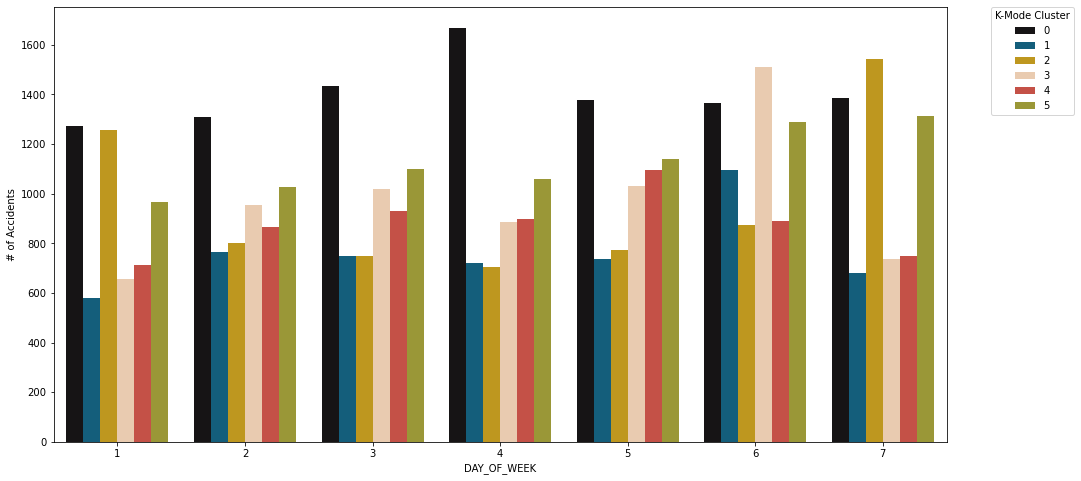

In [29]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x='DAY_OF_WEEK', hue='KMODE_CLUSTER', data=cat_crash_df)
# plt.ylim(0, 1400)
plt.legend(title='K-Mode Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.ylabel('# of Accidents')
plt.savefig('images/day_clusters.png')
plt.show()

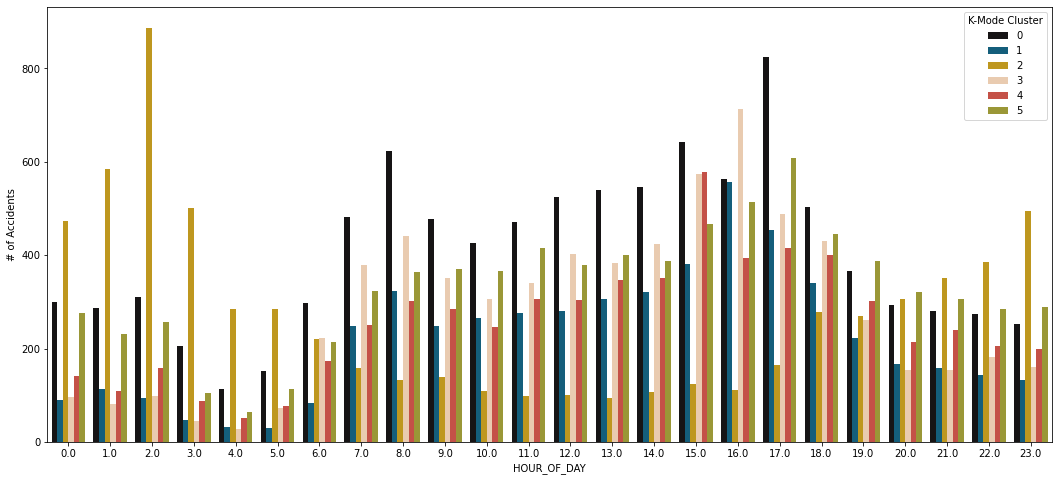

In [30]:
fig, ax = plt.subplots(figsize=(18,8))
sns.countplot(x='HOUR_OF_DAY', hue='KMODE_CLUSTER', data=cat_crash_df[cat_crash_df['HOUR_OF_DAY'] != 99.0])
plt.legend(title='K-Mode Cluster')#, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.ylabel('# of Accidents')
plt.savefig('images/hour_clusters.png')
plt.show()

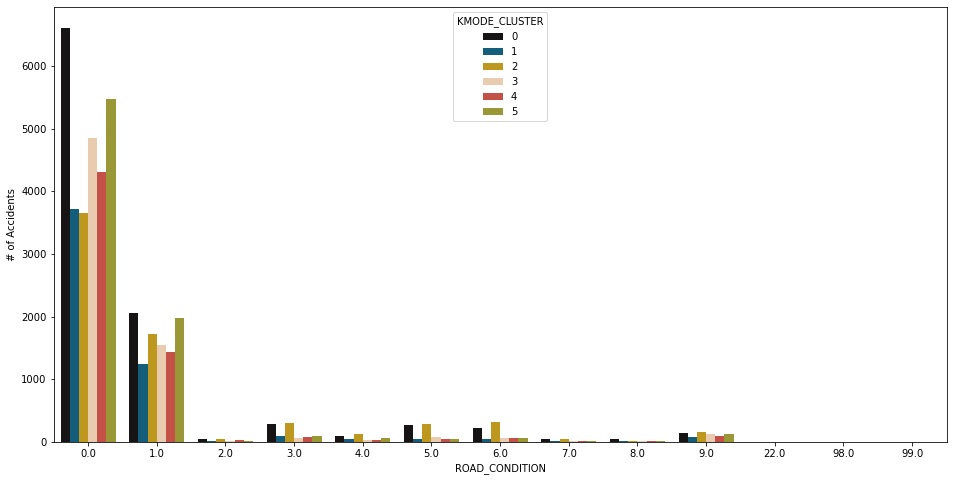

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x='ROAD_CONDITION', hue='KMODE_CLUSTER', data=cat_crash_df)
# plt.ylim(0, 1400)
# plt.legend(title='K-Mode Cluster', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.ylabel('# of Accidents')
plt.savefig('images/road_condition_clusters.png')
plt.show()

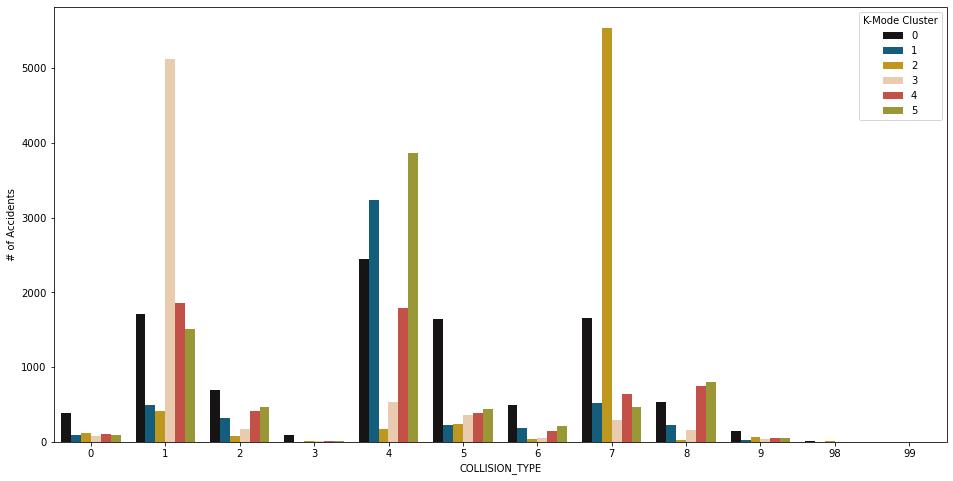

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(x='COLLISION_TYPE', hue='KMODE_CLUSTER', data=cat_crash_df)
# plt.ylim(0, 1400)
plt.legend(title='K-Mode Cluster', loc=1)
plt.ylabel('# of Accidents')
plt.savefig('images/collision_type_clusters.png')
plt.show()

### Percent Prevalence of Each Class for Each Categorical Variable

In [33]:
def cat_percentages(col):
    for i in range(6):
        print('Cluster:', i)
        df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == i].reset_index(drop=True)
        print(df[col].value_counts() / len(df))
        print('\n')

In [34]:
for col in non_binary_cats:
    cat_percentages(col)

Cluster: 0
5     0.101080
12    0.088547
1     0.086407
7     0.084879
6     0.083147
2     0.082331
3     0.081007
11    0.080599
9     0.080192
8     0.079173
4     0.077135
10    0.075504
Name: CRASH_MONTH, dtype: float64


Cluster: 1
11    0.111466
10    0.090073
12    0.086508
8     0.084819
7     0.083318
1     0.083318
2     0.080128
3     0.079377
5     0.078814
6     0.077313
4     0.073747
9     0.071120
Name: CRASH_MONTH, dtype: float64


Cluster: 2
1     0.146567
12    0.114627
2     0.101940
11    0.095373
3     0.081343
10    0.080299
9     0.072687
7     0.065970
4     0.062388
5     0.062090
6     0.060000
8     0.056716
Name: CRASH_MONTH, dtype: float64


Cluster: 3
10    0.123473
11    0.089036
7     0.086534
8     0.086093
9     0.085946
6     0.082266
12    0.078882
3     0.076674
4     0.076085
5     0.075055
2     0.074172
1     0.065784
Name: CRASH_MONTH, dtype: float64


Cluster: 4
1     0.095199
8     0.091782
9     0.090317
5     0.087063
7     0.085110
6     

0     0.937307
2     0.015600
6     0.013539
1     0.011332
7     0.008094
3     0.006917
5     0.002649
4     0.002355
10    0.002208
Name: INTERSECT_TYPE, dtype: float64


Cluster: 4
1     0.408299
2     0.362408
3     0.066395
6     0.062164
7     0.036778
10    0.036778
5     0.019854
4     0.006021
9     0.000651
11    0.000488
8     0.000163
Name: INTERSECT_TYPE, dtype: float64


Cluster: 5
1     0.723256
2     0.206229
5     0.035448
3     0.015951
10    0.007216
4     0.005697
7     0.002279
6     0.002279
0     0.001393
11    0.000253
Name: INTERSECT_TYPE, dtype: float64


Cluster: 0
0    0.934787
2    0.038618
3    0.019870
8    0.002853
4    0.001630
1    0.001121
9    0.000611
7    0.000509
Name: TCD_TYPE, dtype: float64


Cluster: 1
3    0.791518
0    0.165509
4    0.030963
8    0.008069
9    0.001501
7    0.001314
6    0.000563
5    0.000375
2    0.000188
Name: TCD_TYPE, dtype: float64


Cluster: 2
0    0.908358
2    0.057313
3    0.010000
8    0.007761
4    0.007164
1   

### Cluster Plots

In [35]:
cat_crash_df = pd.merge(cat_crash_df, crash_df[['CRASH_CRN', 'DEC_LAT', 'DEC_LONG']], on=['CRASH_CRN'])

In [36]:
geo_df = cat_crash_df.dropna(subset=['DEC_LAT', 'DEC_LONG'])

#### Interactive Plot

In [53]:
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_mapbox(
    lon=cat_crash_df['DEC_LONG'],
    lat=cat_crash_df['DEC_LAT'],
    color=cat_crash_df['KMODE_CLUSTER'],
    color_discrete_sequence=colors
)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(
        title = 'Pittsburgh Automobile Accidents (2010-2019)',
        geo_scope='usa'
    )

fig.show()

#### K-Modes Cluster 0

In [38]:
cluster_0_df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == 0]

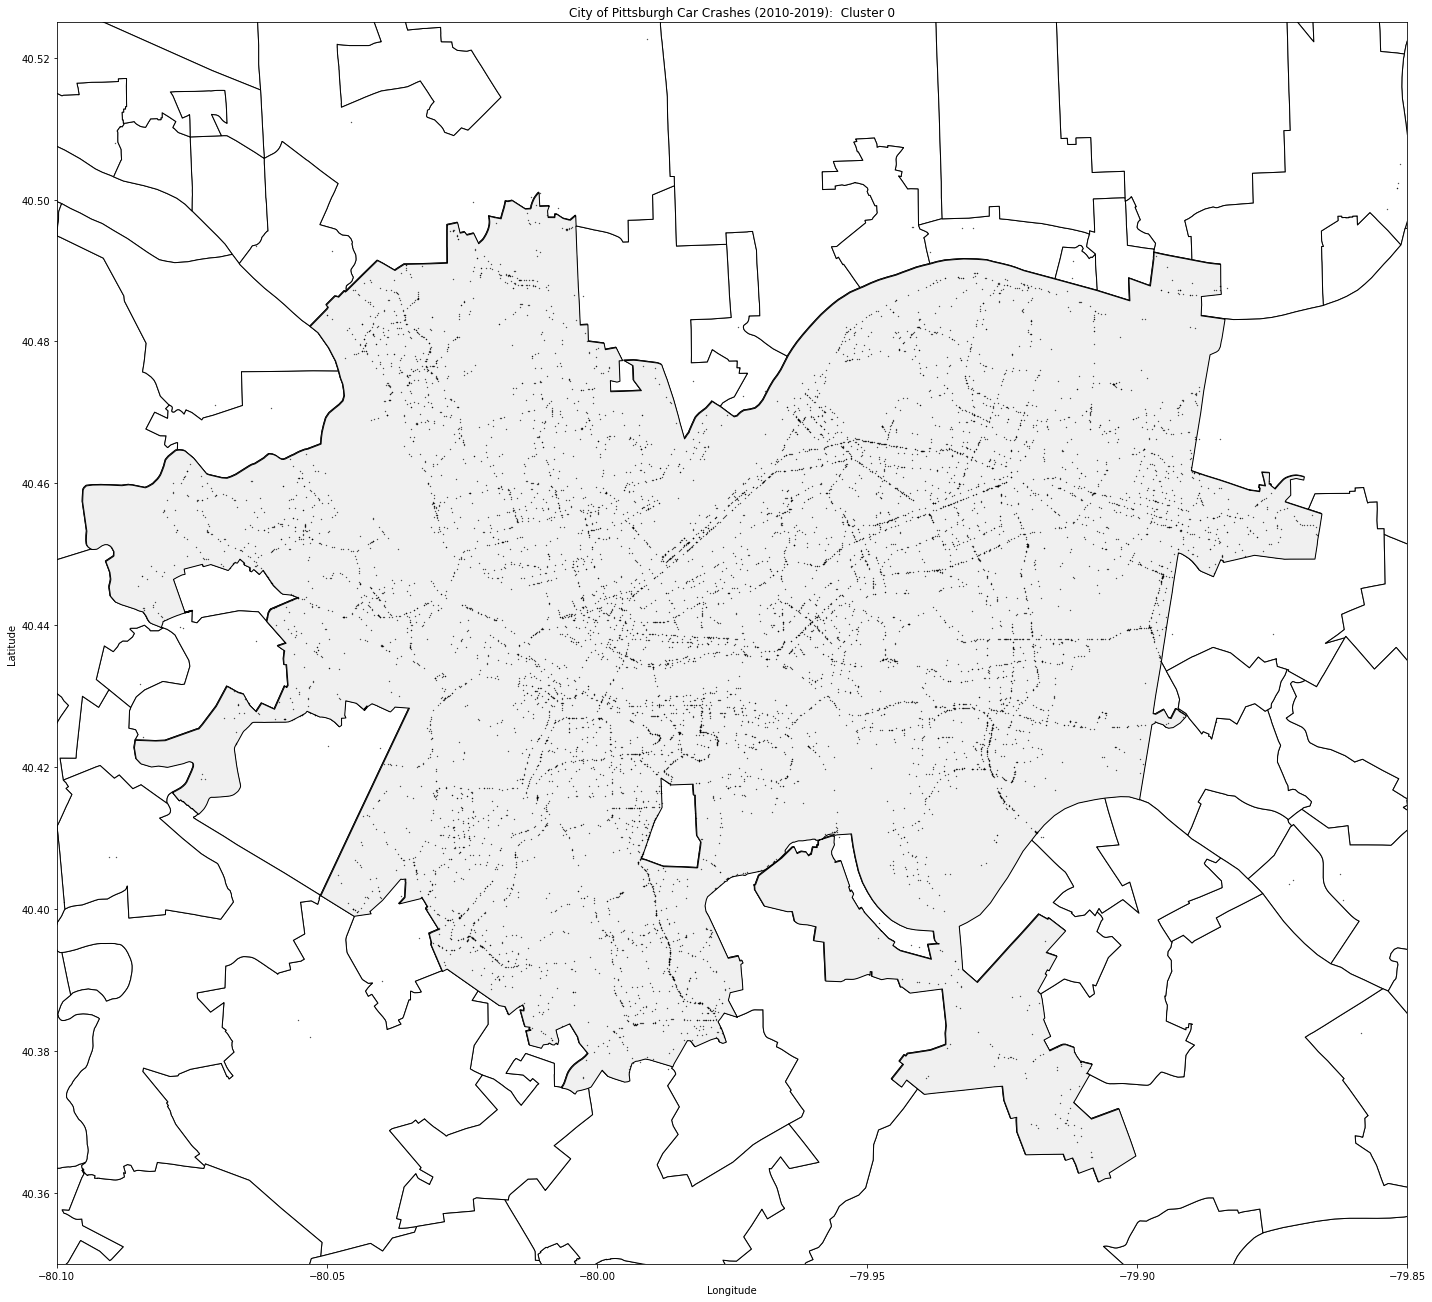

In [39]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=cluster_0_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=cluster_0_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='black', 
            marker='.',
            s=0.4)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Pittsburgh Car Crashes (2010-2019):  Cluster 0')
plt.tight_layout()
plt.savefig('images/k_modes_cluster_0.png')
plt.show()

#### K-Modes Cluster 1

In [40]:
cluster_1_df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == 1]

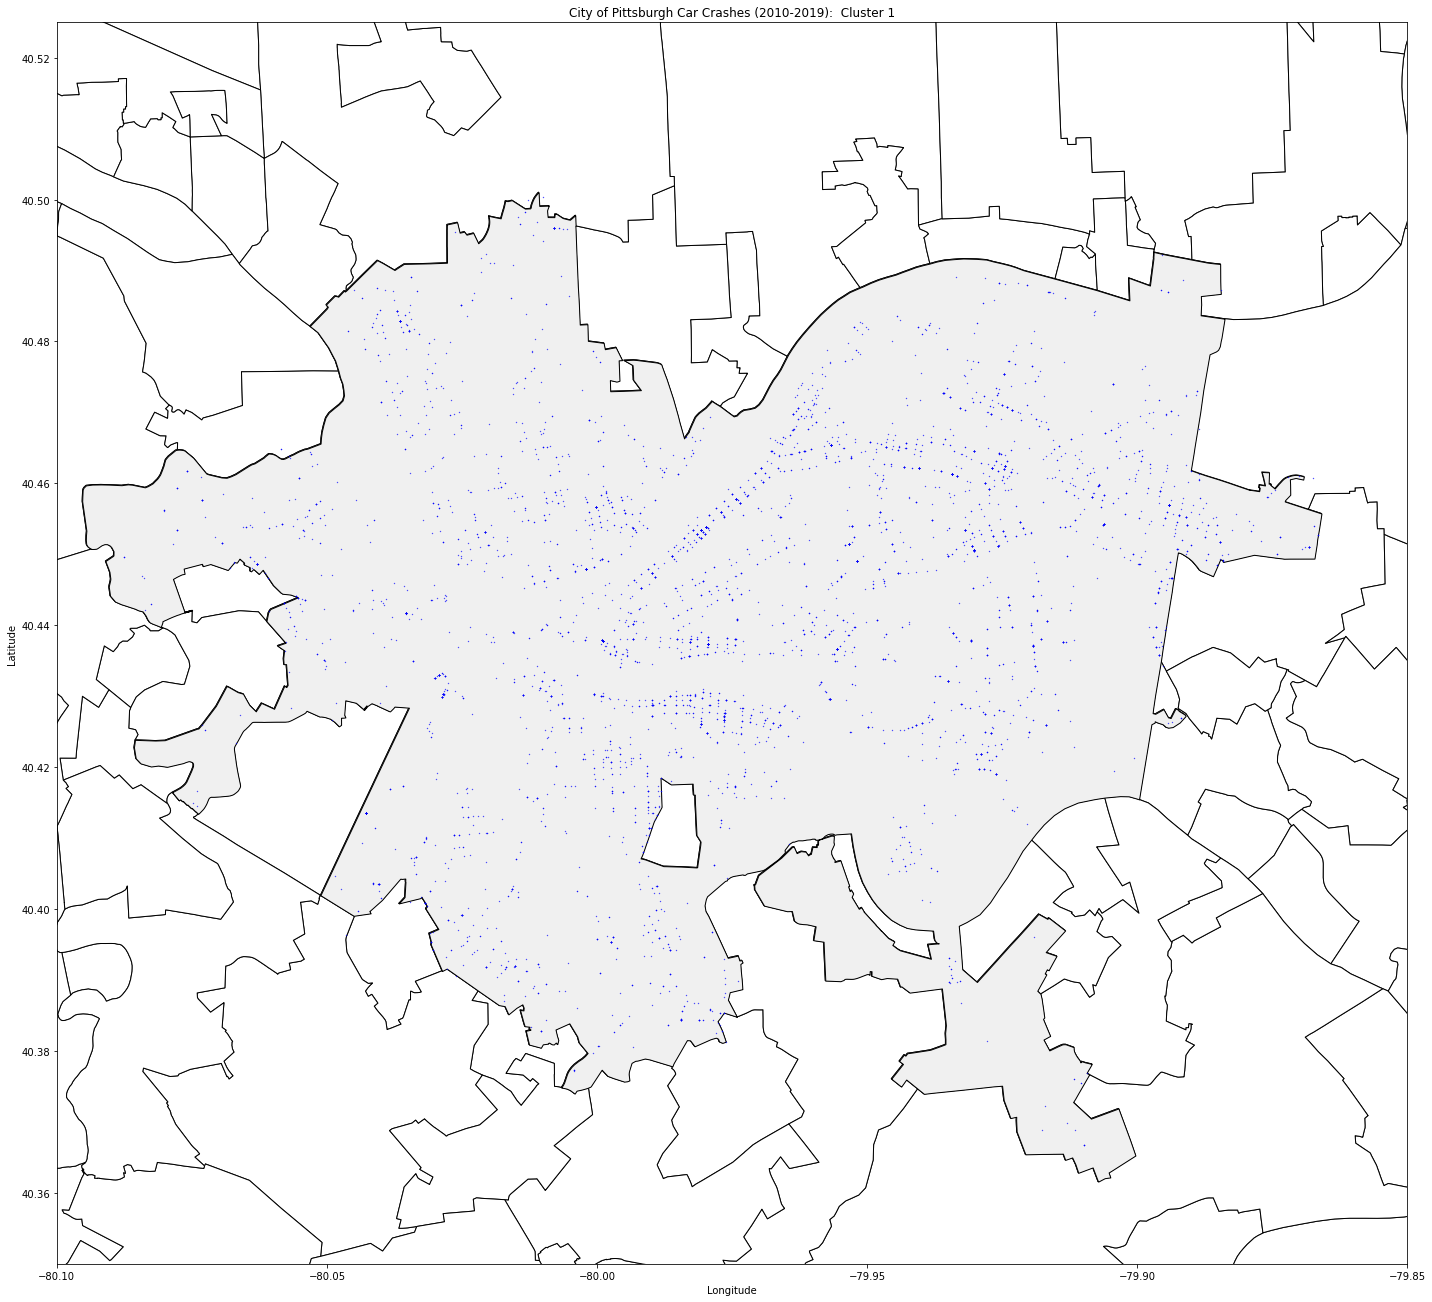

In [41]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=cluster_1_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=cluster_1_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='blue', 
            marker='.',
            s=0.4)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Pittsburgh Car Crashes (2010-2019):  Cluster 1')
plt.tight_layout()
plt.savefig('images/k_modes_cluster_1.png')
plt.show()

#### K-Modes Cluster 2

In [42]:
cluster_2_df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == 2]

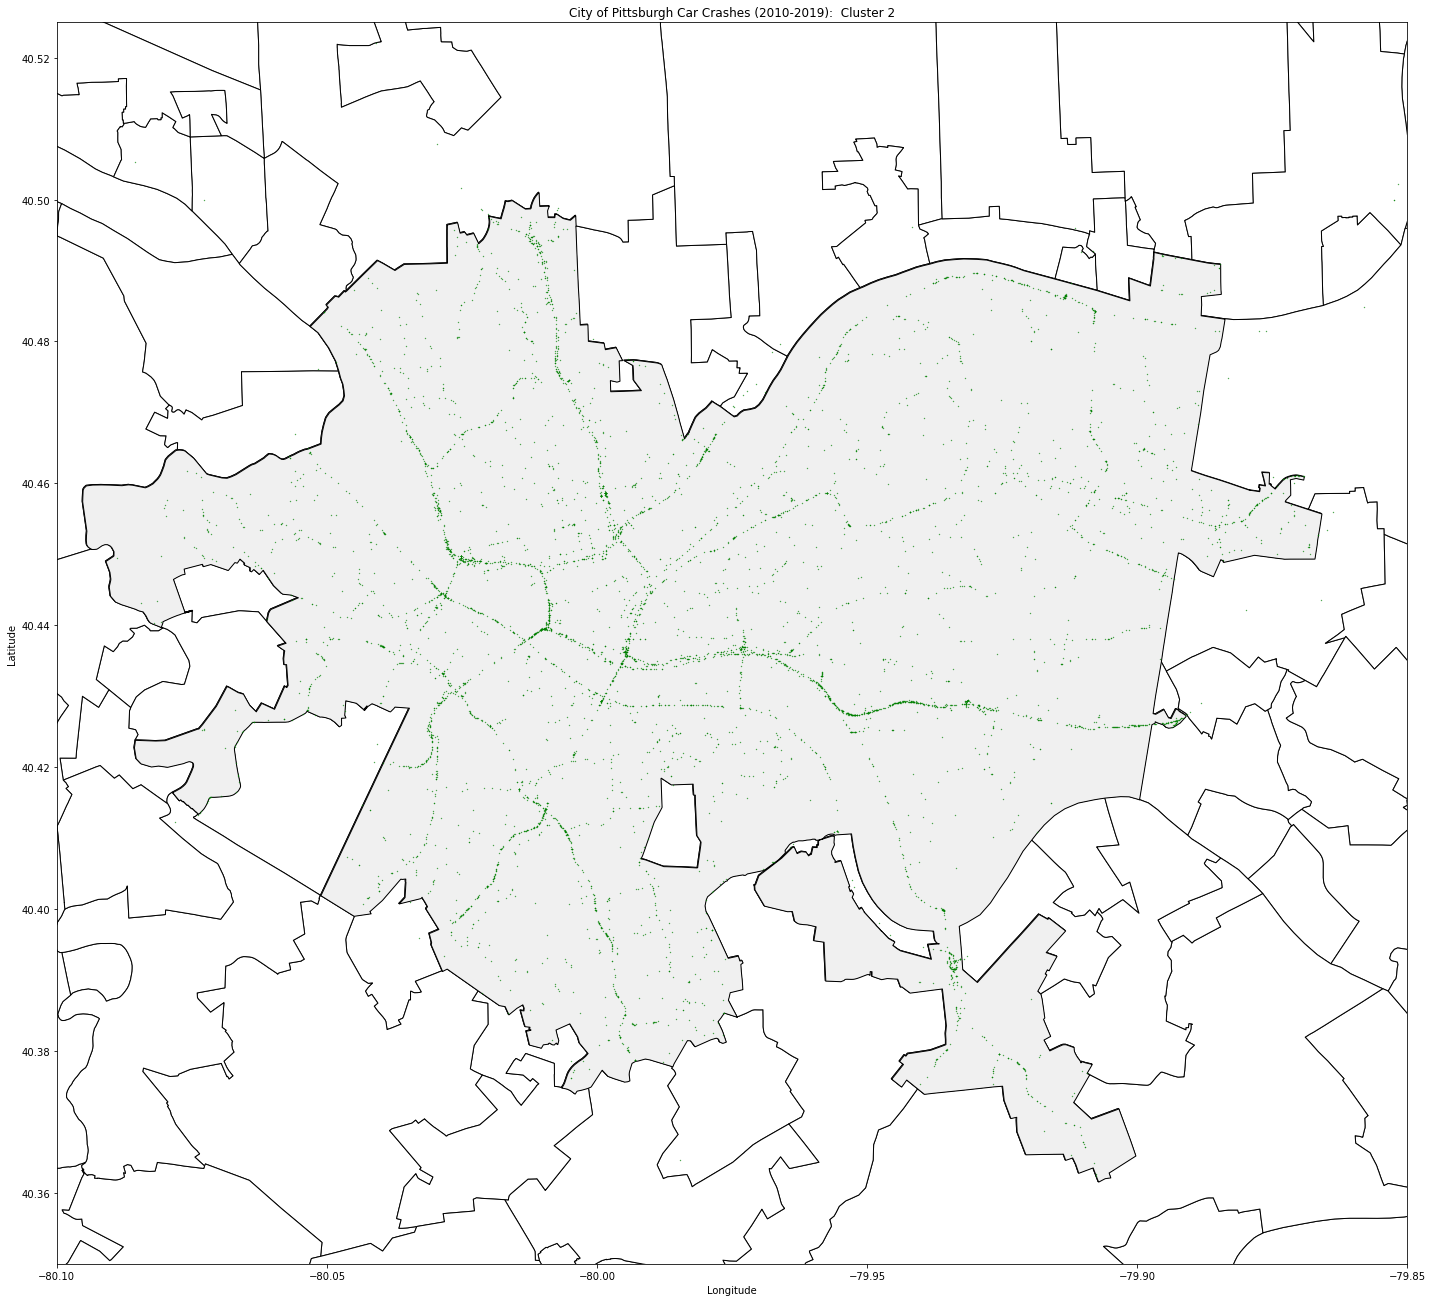

In [43]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=cluster_2_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=cluster_2_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='green', 
            marker='.',
            s=0.4)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Pittsburgh Car Crashes (2010-2019):  Cluster 2')
plt.tight_layout()
plt.savefig('images/k_modes_cluster_2.png')
plt.show()

#### K-Modes Cluster 3

In [44]:
cluster_3_df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == 3]

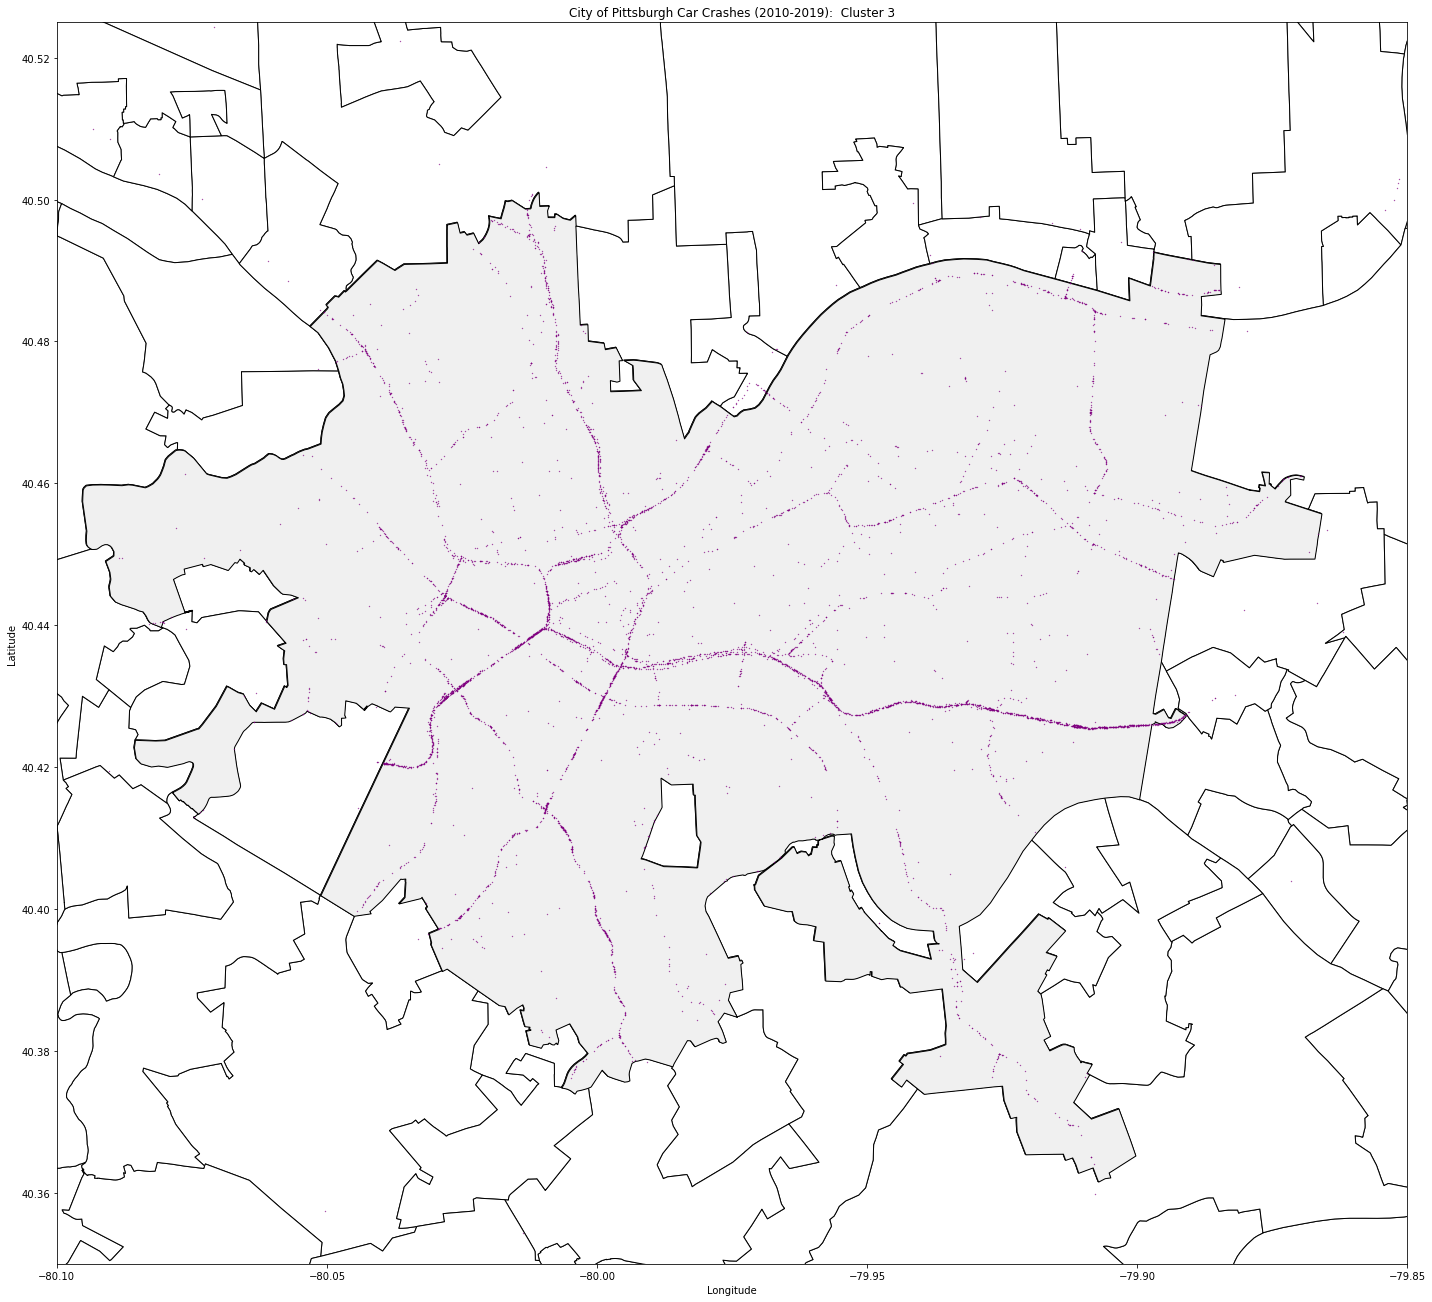

In [45]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=cluster_3_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=cluster_3_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='purple', 
            marker='.',
            s=0.4)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Pittsburgh Car Crashes (2010-2019):  Cluster 3')
plt.tight_layout()
plt.savefig('images/k_modes_cluster_3.png')
plt.show()

#### K-Modes Cluster 4

In [46]:
cluster_4_df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == 4]

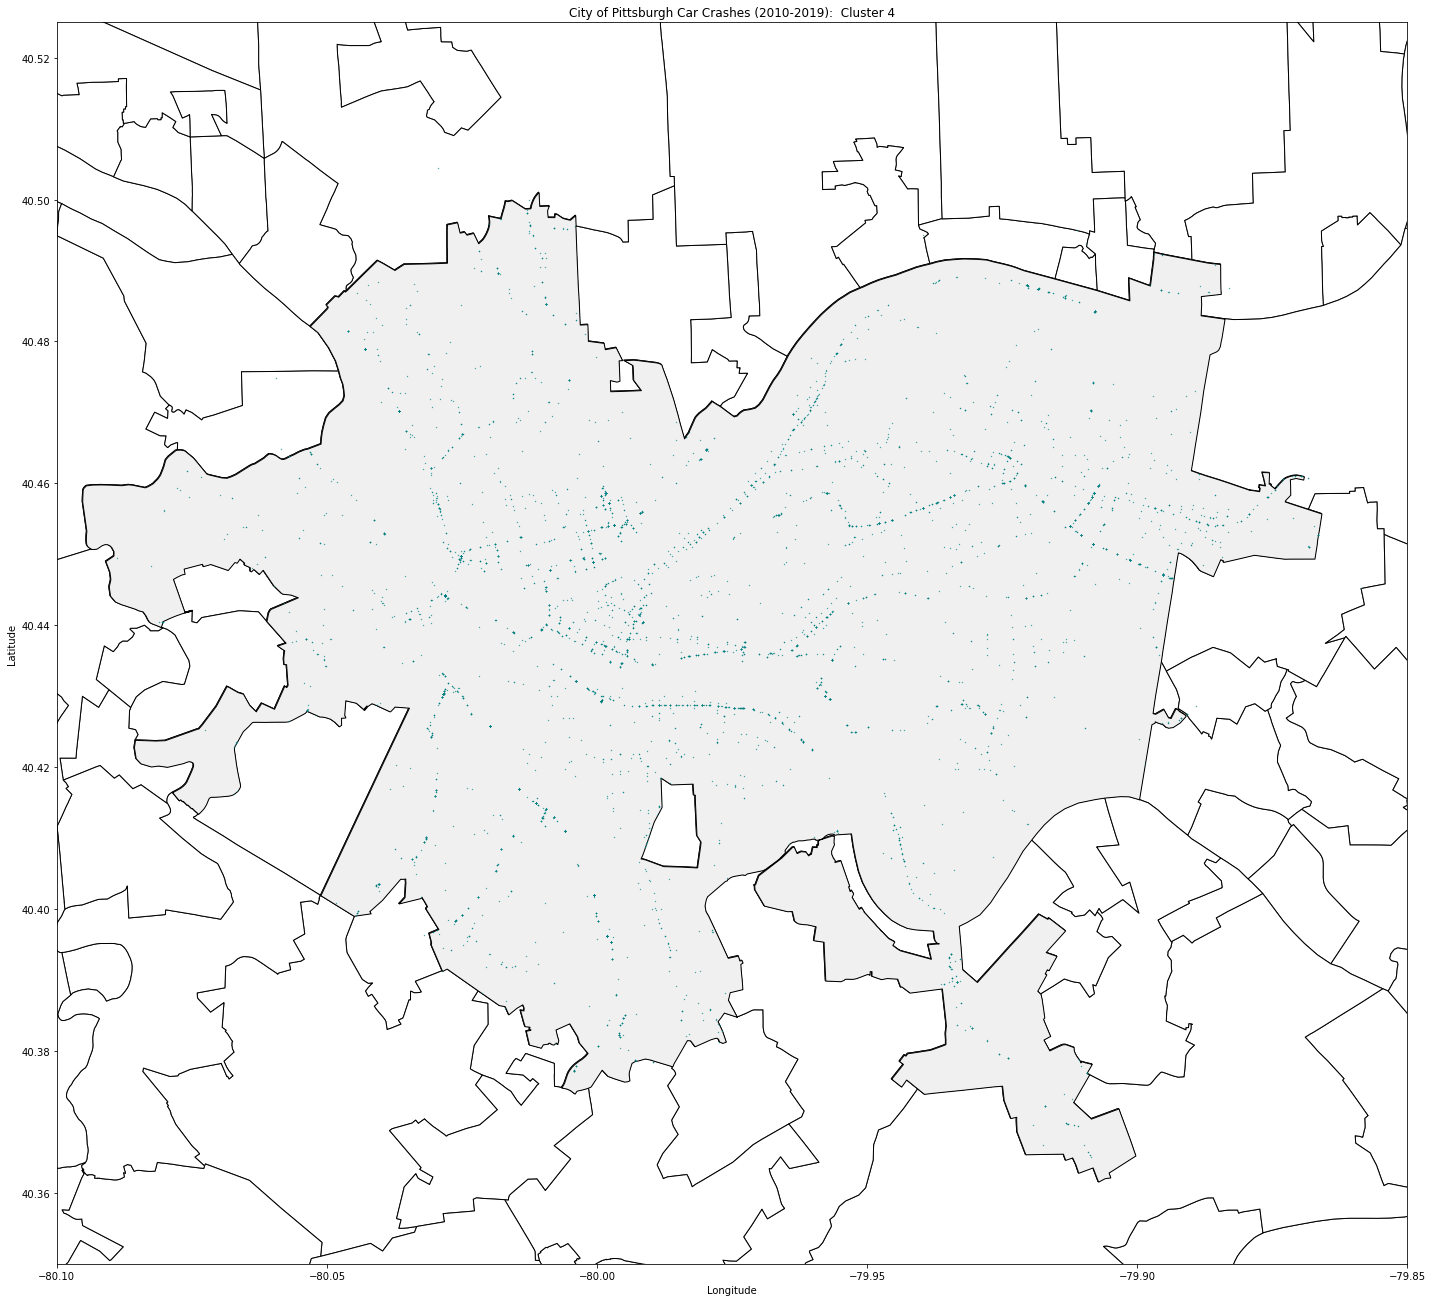

In [47]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=cluster_4_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=cluster_4_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='teal', 
            marker='.',
            s=0.4)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Pittsburgh Car Crashes (2010-2019):  Cluster 4')
plt.tight_layout()
plt.savefig('images/k_modes_cluster_4.png')
plt.show()

#### K-Modes Cluster 5

In [48]:
cluster_5_df = cat_crash_df.loc[cat_crash_df['KMODE_CLUSTER'] == 5]

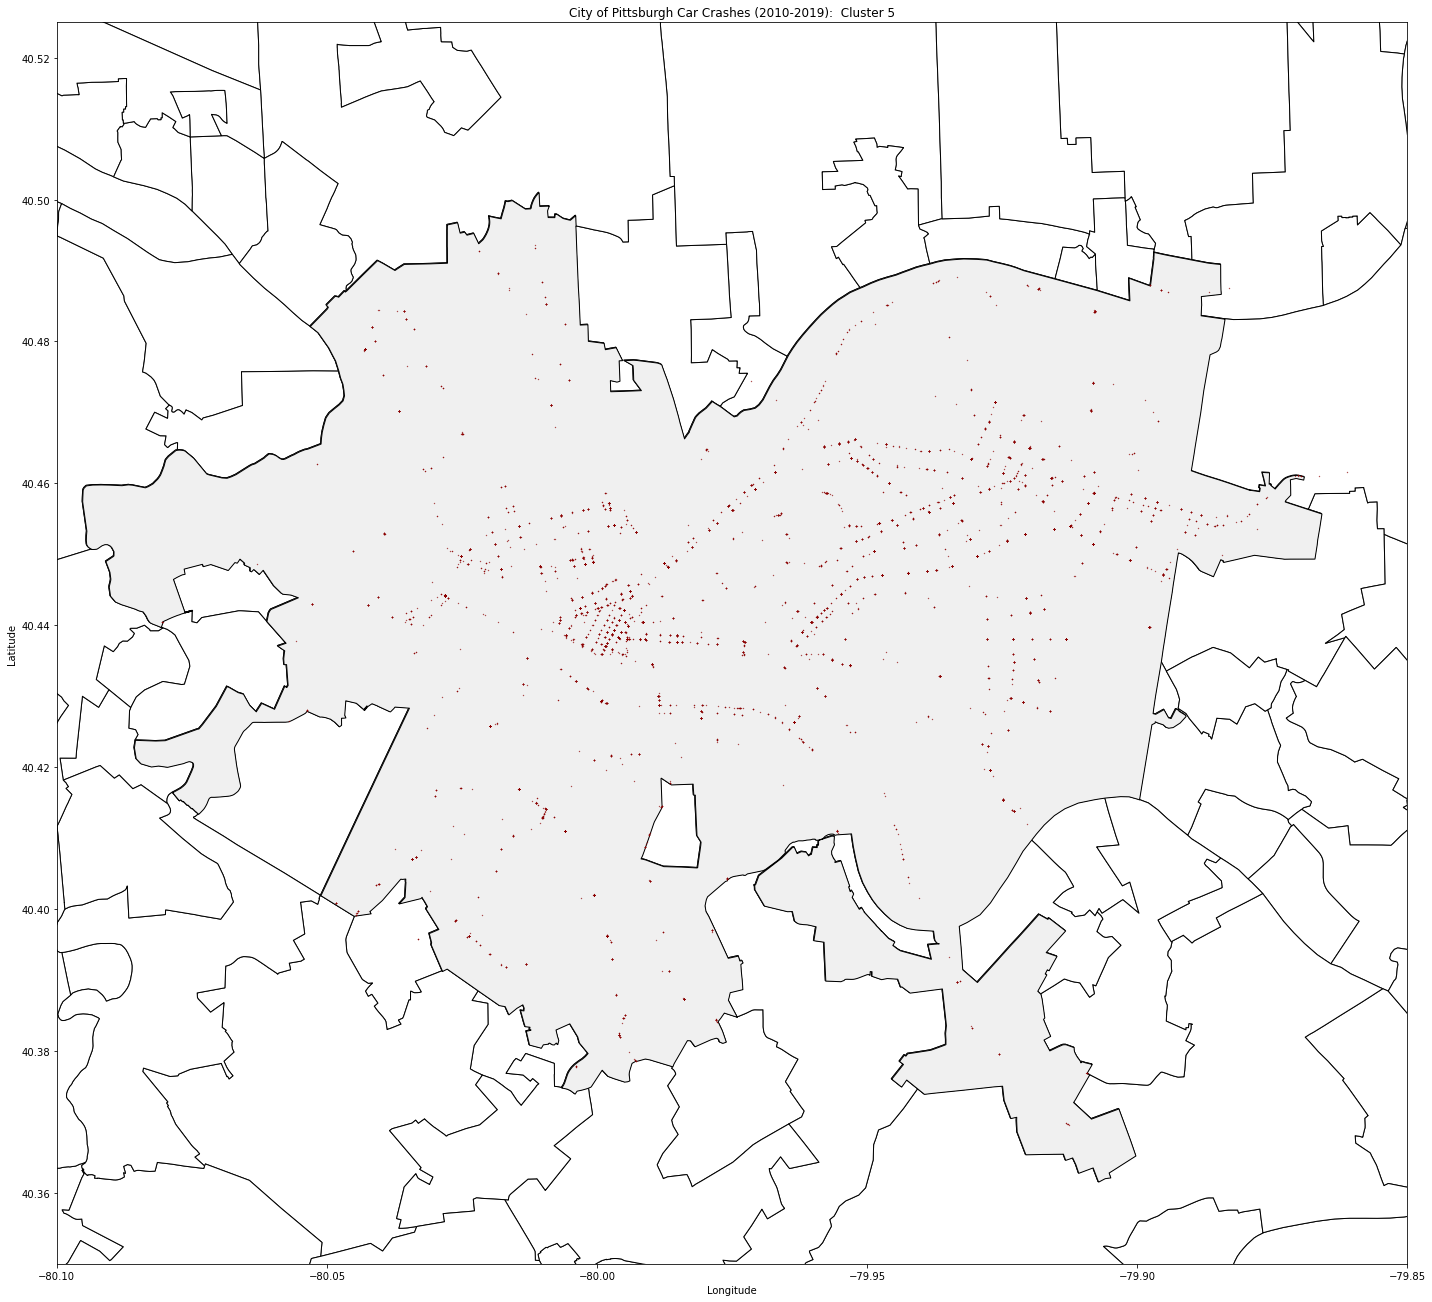

In [49]:
fig, ax = plt.subplots(figsize=(20,20))

munis.plot(color='white', edgecolor='black', ax=ax)
munis_pittsburgh.plot(color='#F0F0F0', edgecolor='black', ax=ax)

ax.scatter(x=cluster_5_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LONG'].values, 
            y=cluster_5_df.dropna(subset=['DEC_LONG', 'DEC_LAT'])['DEC_LAT'].values, 
            color='darkred', 
            marker='.',
            s=0.4)
plt.xlim((-80.1, -79.85))
plt.ylim((40.35, 40.525))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City of Pittsburgh Car Crashes (2010-2019):  Cluster 5')
plt.tight_layout()
plt.savefig('images/k_modes_cluster_5.png')
plt.show()